In [25]:
import pandas as pd
import numpy as np
import itertools
import math
import time
import sys
sys.path.insert(0, '../..')

import matplotlib.pyplot as plt

from g4l.data import Sample
import g4l.display

from g4l.estimators import CTM
from g4l.estimators import Prune
from g4l.estimators import SMC
import g4l.tree.generation as gen
import g4l.tree as tree

## Pruning vs SMC forest generation comparison

This notebook explores the differences between the context trees generated by two different methods: The first method is the Smallest Maximizer Criterion (G4L) and the second one is a pruning procedure over an initial complete context tree.

In [26]:
max_depth = 4
X = Sample('../example1/folha.txt', [0, 1, 2, 3, 4])
print("sample size: ", X.len())

sample size:  97750


In [27]:
start_time = time.time()
t_incr = tree.ContextTree(X, max_depth=max_depth, tree_initialization_method=gen.incremental)
print("Completed in", round(time.time() - start_time, 2), "seconds")

Completed in 0.44 seconds


____

__Estimating trees by pruning method:__

The pruning method is many times faster than the previous method. Among many factors, one remarkable reason is that it calls CTM method only once.

In [28]:
start_time = time.time()
prune_trees = Prune(t_incr)
prune_trees.execute()
print("Completed in", round(time.time() - start_time, 2), "seconds")

Completed in 7.38 seconds


__Estimating trees by SMC method:__

In [ ]:
start_time = time.time()
smc_trees = SMC(t_incr)
smc_trees.execute(penalty_interval=(0.1, 400), epsilon=0.01)
print("Completed in", round(time.time() - start_time, 2), "seconds")

__Creating summaries for estimation methods outcomes__

In [6]:
prune_results = np.array([[t.num_contexts(), t.log_likelihood(), t.to_str()] for t in prune_trees.context_trees]).T
smc_results = np.array([[t.num_contexts(), t.log_likelihood(), t.to_str()] for t in smc_trees.context_trees]).T

# Tree generation summary for pruning method
prune_summary = pd.DataFrame(prune_results.T, columns=['num_contexts', 'log-likelihood', 'tree'])
prune_summary['num_contexts'] = prune_summary['num_contexts'].astype(int)
prune_summary = prune_summary.sort_values(['num_contexts'])

# Tree generation summary for SMC method
smc_summary = pd.DataFrame(smc_results.T, columns=['num_contexts', 'log-likelihood', 'tree'])
smc_summary['num_contexts'] = smc_summary['num_contexts'].astype(int)
smc_summary = smc_summary.sort_values(['num_contexts'])

In [17]:
prune_summary.head(5)

,num_contexts,log-likelihood,tree
0,5,-104345.53413193254,0 1 2 3 4
1,8,-81642.69354625134,00 1 10 2 20 3 30 4
2,11,-77498.39900589187,000 1 10 100 2 20 200 3 30 300 4
3,12,-77435.60088011279,000 01 10 100 2 20 200 21 3 30 300 4
4,13,-77357.30233251062,000 001 10 100 2 20 200 201 21 3 30 300 4


In [18]:
smc_summary.head(5)

,num_contexts,log-likelihood,tree
14,5,-104345.53413193254,0 1 2 3 4
13,8,-81642.69354625134,00 1 10 2 20 3 30 4
12,11,-77498.39900589187,000 1 10 100 2 20 200 3 30 300 4
11,13,-77357.30233251062,000 001 10 100 2 20 200 201 21 3 30 300 4
10,14,-77309.69143269696,000 001 010 100 2 20 200 201 21 210 3 30 300 4


### Comparing trees/likelihoods generated by both methods

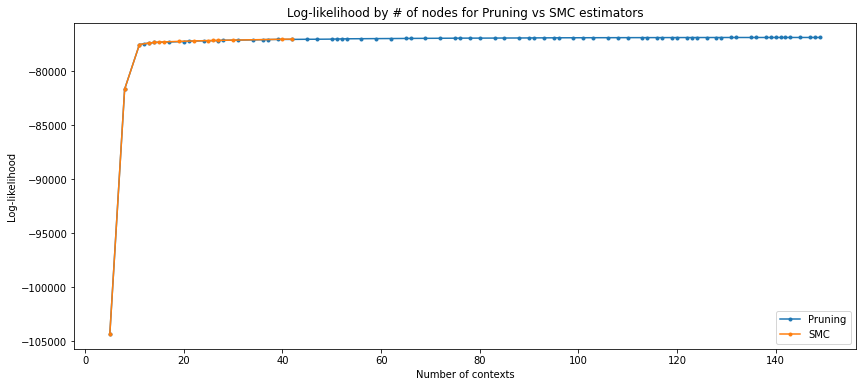

In [9]:
prune_results = np.array([[t.num_contexts(), t.log_likelihood()] for t in prune_trees.context_trees]).T
smc_results = np.array([[t.num_contexts(), t.log_likelihood()] for t in smc_trees.context_trees]).T
plt.figure(figsize=(14, 6))
plt.title('Log-likelihood by # of nodes for Pruning vs SMC estimators')
plt.plot(prune_results[0], prune_results[1], marker='.', label='Pruning')
plt.plot(smc_results[0], smc_results[1], marker='.', label='SMC')
plt.xlabel('Number of contexts')
plt.ylabel('Log-likelihood')
#plt.xlim((10, ))
plt.legend()
plt.show()

__Same view, zoomed between 4 and 25 nodes__

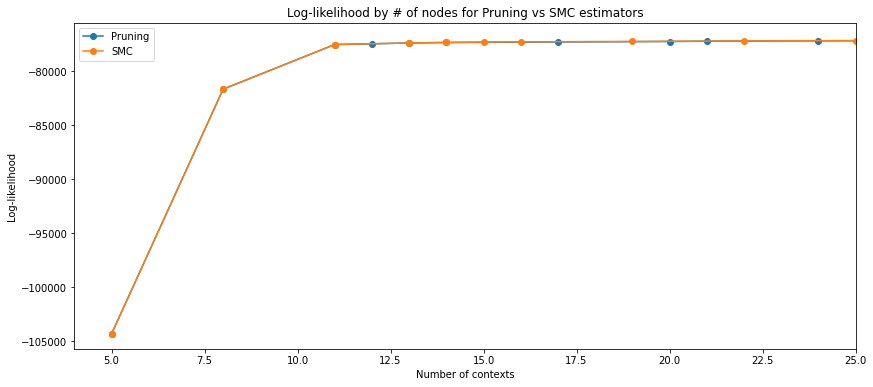

In [11]:
prune_results = np.array([[t.num_contexts(), t.log_likelihood()] for t in prune_trees.context_trees]).T
smc_results = np.array([[t.num_contexts(), t.log_likelihood()] for t in smc_trees.context_trees]).T
plt.figure(figsize=(14, 6))
plt.title('Log-likelihood by # of nodes for Pruning vs SMC estimators')
plt.plot(prune_results[0], prune_results[1], marker='o', label='Pruning')
plt.plot(smc_results[0], smc_results[1], marker='o', label='SMC')
plt.xlabel('Number of contexts')
plt.ylabel('Log-likelihood')
plt.xlim((4, 25))
plt.legend()
plt.show()
# exibir a verossimilhança sem a aplicação da penalização

### Comparing generated trees

__Node expansion from 11 contexts tree to the next one (Pruning method)__

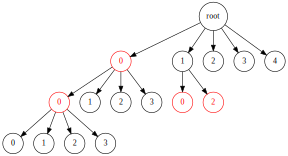

In [12]:
g4l.display.draw_tree(prune_trees.context_trees[3], size='4, 4', previous_tree=prune_trees.context_trees[2])

__Node expansion from 11 contexts tree to the next one (SMC method)__

*This behavior was already observed in previous investigations*

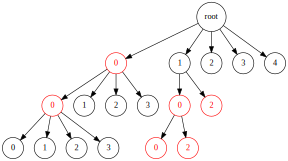

In [13]:
smc_11 = smc_trees.context_trees[12]
smc_11_next = smc_trees.context_trees[11]
g4l.display.draw_tree(smc_11_next, size='4, 4', previous_tree=smc_11) 

__Differences on log-likelihood between the different methods:__

* SMC uses BIC and hence applies penalties over the computed likelihood. It means that the log-likelihood in the nodes of the smallest tree (0 1 2 3 4) may vary, since the same tree can be generated by a range of values for the penalization constant $c$. In this case, the smallest tree will be generated for any $ c > 164.655 $ (approximately).

* However, by scanning different values of $c$ that produces the smallest tree, we observe that the maximum likelihood (empirically found) in the SMC method is different from (and below) the likelihood estimated by pruning (which doesn't require any adjustable parameter).

In [15]:
smallest_pruned_tree = prune_trees.context_trees[0].tree()
pruned_0_lps = smallest_pruned_tree[smallest_pruned_tree.node=='0'].likelihood
pruned_0_lps = pruned_0_lps.values[0]

minval = math.inf
for c in np.arange(164.59, 164.69, 0.001):
    try:
        t = CTM(t_incr).execute(c).tree()
        x = t[t.node=='0'].likelihood.values[0]
        minval = min(minval, x)
        if minval==x:
            print('c: ', c)
            print('Likelihood found using smc method: ', minval)
            break
    except:
        pass

print('Likelihood found using pruning method: ', pruned_0_lps)

c:  164.6550000000003
Likelihood found using smc method:  -62840.152905308016
Likelihood found using pruning method:  -62840.152905308016


In [20]:
CTM(t_incr).execute(200).tree().sort_values(['likelihood']).head(5)

,node_idx,active,depth,depth_idx,freq,likelihood,node,num_child_nodes,parent_idx
2,2,1,1,2,44111,-62840.152905,0,4.0,None
1,1,1,1,1,21830,-18794.382713,1,2.0,None
0,0,1,1,0,21830,-14715.435172,2,4.0,None
3,3,1,1,3,7909,-6671.568838,3,4.0,None
4,4,1,1,4,2070,-1323.994503,4,3.0,None


In [21]:
CTM(t_incr).execute(300).tree().sort_values(['likelihood']).head(5)

,node_idx,active,depth,depth_idx,freq,likelihood,node,num_child_nodes,parent_idx
2,2,1,1,2,44111,-62840.152905,0,4.0,None
1,1,1,1,1,21830,-18794.382713,1,2.0,None
0,0,1,1,0,21830,-14715.435172,2,4.0,None
3,3,1,1,3,7909,-6671.568838,3,4.0,None
4,4,1,1,4,2070,-1323.994503,4,3.0,None


____

__Are the generated trees of same size equal for both methods?__

Some of them. Different trees for the same size were also found. It's observable that the methods generate trees of different sizes.

Equal trees (# of nodes):  [5, 8, 11, 13, 14]
Different trees (# of nodes):  [27, 42]


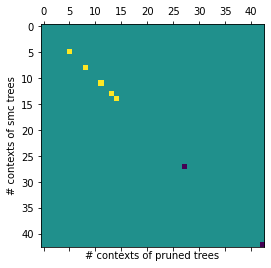

In [22]:
px = pd.DataFrame([[x.num_contexts(), x.to_str()] for x in prune_trees.context_trees], columns=['a', 'b']).set_index(['a'])
sx = pd.DataFrame(reversed([[x.num_contexts(), x.to_str()] for x in smc_trees.context_trees]), columns=['a', 'b']).set_index(['a'])
minnodes = min(px.index.max(), sx.index.max())
M = np.zeros((minnodes+1, minnodes+1))
equal_trees = []
diff_trees = []
for x in list(px.index):
    for y in list(sx.index):
        try:
            if x==y:
                if px.loc[x].b==sx.loc[y].b:
                    M[x, y] = 1
                    equal_trees.append(x)
                    pass
                else:
                    M[x, y] = -1
                    diff_trees.append(x)
        except KeyError:
            pass
        #if px.loc[x]
#    print(sx.iloc[i].a)

#plt.figure(figsize=[16, 16])
print("Equal trees (# of nodes): ", equal_trees)
print("Different trees (# of nodes): ", diff_trees)
plt.matshow(M)
plt.xlabel("# contexts of pruned trees")
plt.ylabel("# contexts of smc trees")
plt.show()

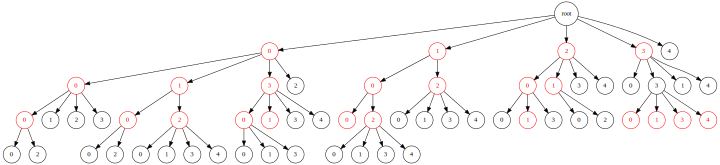

In [23]:
prune_42 = [t for t in prune_trees.context_trees if t.num_contexts()==42][0]
smc_42 = [t for t in smc_trees.context_trees if t.num_contexts()==42][0]

g4l.display.draw_tree(prune_42, size='10, 10', previous_tree=smc_42)

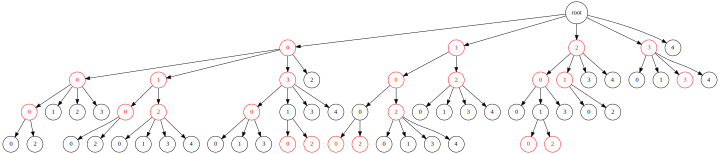

In [24]:
g4l.display.draw_tree(smc_42, size='10, 10', previous_tree=prune_42)

In [60]:
xx = CTM(t_incr).execute(300).tree().sort_values(['lps'])
xx.head(5)

,node_idx,active,depth,depth_idx,freq,lps,node,num_child_nodes,parent_idx,type
2,2,1,1,2,44111,-76628.355079,0,4.0,None,N
1,1,1,1,1,21830,-32582.584886,1,2.0,None,N
0,0,1,1,0,21830,-28503.637346,2,4.0,None,N
3,3,1,1,3,7909,-20459.771012,3,4.0,None,N
4,4,1,1,4,2070,-15112.196676,4,3.0,None,N
